In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/test_images320x480.zip'

### Dependencies

In [4]:
from utillity_script_cloud_segmentation import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
#@title

class AdamAccumulated(optimizers.Optimizer):
    """Adam optimizer with gradient accumulation.
    Default parameters follow those provided in the original paper.
    # Arguments
        accumulation_steps: int > 0. Update gradient in every accumulation steps.
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, accumulation_steps, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, **kwargs):
        super(AdamAccumulated, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.accumulation_steps = K.variable(accumulation_steps, dtype='int64', name='accumulation_steps')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        update_cond = K.equal((self.iterations + 1) % self.accumulation_steps, 0)
        sub_step = self.iterations % self.accumulation_steps + 1
        t = K.cast(self.iterations // self.accumulation_steps, K.floatx()) + 1

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))
        lr_t = K.switch(update_cond, lr_t, 0.0)

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]
        self.weights = [self.iterations] + ms + vs + vhats

        acc_grads = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        for grad, acc_grad in zip(grads, acc_grads):
            ave_grad = grad / K.cast(self.accumulation_steps, K.floatx())
            self.updates.append(K.update(
                acc_grad,
                K.switch(
                    K.equal(sub_step, 1),
                    ave_grad,
                    acc_grad + (ave_grad - acc_grad) / K.cast(sub_step, K.floatx())
                ),
            ))
        grads = [K.switch(update_cond, grad, K.zeros_like(grad)) for grad in acc_grads]

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = K.switch(update_cond, (self.beta_1 * m) + (1. - self.beta_1) * g, m)
            v_t = K.switch(update_cond, (self.beta_2 * v) + (1. - self.beta_2) * K.square(g), v)
            if self.amsgrad:
                vhat_t = K.switch(update_cond, K.maximum(vhat, v_t), vhat)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'accumulation_steps': int(K.get_value(self.accumulation_steps)),
                  'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdamAccumulated, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
classification_model_base_path = base_path + 'Models/files/classification/'
classification_model_path = classification_model_base_path + '19-EfficientNetB0_224x224_Cyclical_triangular.h5'
segmentation_model_base_path = base_path + 'Models/files/segmentation/'
segmentation_model_path = segmentation_model_base_path + '68-unet_efficientnetb0_320x480.h5'
submission_base_path = data_path + 'submissions/inference/'
test_path = data_path + 'sample_submission.csv'
test_images_path = 'test_images/'

### Load data

In [7]:
submission = pd.read_csv(test_path)
print('Test samples:', len(submission))

# Preprocecss data
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(test.head())

Test samples: 14792


,image
0,002f507.jpg
1,0035ae9.jpg
2,0038327.jpg
3,004f759.jpg
4,005ba08.jpg


# Model parameters

In [0]:
BACKBONE = 'efficientnetb0'
CLASS_HEIGHT = 224
CLASS_WIDTH = 224
SEG_HEIGHT = 320
SEG_WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
TTA_STEPS = 8
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
best_tresholds_class = [0.64, 0.52, 0.61, 0.59] # beta 0.5
best_tresholds_class2 = [0.46, 0.29, 0.49, 0.4] # beta 1
best_tresholds_seg = [0.45, 0.35, 0.5, 0.45]
best_masks_seg = [20000, 17500, 17500, 10000]

model_name = '50-[seg]68-UNet EfficientNetB0[class]19-EfficientNetB0'
submission_post_path = submission_base_path + '%s_submission_post.csv' % (model_name)
submission_post_class_path = submission_base_path + '%s_submission_post_class.csv' % (model_name)
submission_post_class2_path = submission_base_path + '%s_submission_post_class2.csv' % (model_name)
submission_post_tta_path = submission_base_path + '%s_submission_post_tta.csv' % (model_name)
submission_post_tta_class_path = submission_base_path + '%s_submission_post_class_tta.csv' % (model_name)
submission_post_tta_class2_path = submission_base_path + '%s_submission_post_class2_tta.csv' % (model_name)

In [0]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [0]:
classification_model = load_model(classification_model_path)
segmentation_model = load_model(segmentation_model_path, custom_objects={'AdamAccumulated':AdamAccumulated, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

### Classification data generator

In [15]:
test_datagen=ImageDataGenerator(rescale=1./255.,
                                vertical_flip=True,
                                horizontal_flip=True,
                                zoom_range=[1, 1.2],
                                fill_mode='constant',
                                cval=0.)

classification_test_generator=test_datagen.flow_from_dataframe(
                                            dataframe=test,
                                            directory=test_images_path,
                                            x_col="image",
                                            target_size=(CLASS_HEIGHT, CLASS_WIDTH),
                                            class_mode=None,
                                            batch_size=1,
                                            shuffle=False,
                                            seed=seed)

Found 3698 validated image filenames.


# Apply segmentation model to test set

In [0]:
#@title
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(SEG_HEIGHT, SEG_WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks[..., class_index]
            pred_mask = post_process(pred_mask, threshold=.5, min_size=0)
            pred_masks[...,class_index] = pred_mask

        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

X_test = pd.concat(test_df)

# Using TTA Wrapper

In [17]:
segmentation_model_tta = tta_segmentation(segmentation_model, h_flip=True, v_flip=True, merge='mean')
segmentation_model_tta.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 320, 480, 3)          0         
_________________________________________________________________
repeat_1 (Repeat)            (4, 320, 480, 3)          0         
_________________________________________________________________
tta_1 (TTA)                  (4, 320, 480, 3)          0         
_________________________________________________________________
model_1 (Model)              multiple                  10115936  
_________________________________________________________________
tta_2 (TTA)                  (4, 320, 480, 4)          0         
_________________________________________________________________
merge_1 (Merge)              (1, 320, 480, 4)          0         
Total params: 10,115,936
Trainable params: 10,071,936
Non-trainable params: 44,000
_________________________________________

# Apply segmentation model to test set (TTA)

In [0]:
#@title
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(SEG_HEIGHT, SEG_WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model_tta.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks[..., class_index]
            pred_mask = post_process(pred_mask, threshold=.5, min_size=0)
            pred_masks[...,class_index] = pred_mask

        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels_tta'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post_tta'] = pred_rles_post
        
        test_df.append(image_df)

X_test_tta = pd.concat(test_df)

# Apply classifcation model to test set

In [0]:
test_class_preds = apply_tta(classification_model, classification_test_generator, steps=TTA_STEPS)
test_class_preds2 = np.copy(test_class_preds)

for index in range(len(label_columns)):
  test_class_preds[:,index] = (test_class_preds[:,index] > best_tresholds_class[index]).astype(int)
  test_class_preds2[:,index] = (test_class_preds2[:,index] > best_tresholds_class2[index]).astype(int)
  
X_test['empty_mask'] = test_class_preds.reshape(test_class_preds.shape[0]*N_CLASSES)
X_test['empty_mask2'] = test_class_preds2.reshape(test_class_preds2.shape[0]*N_CLASSES)
X_test_tta['empty_mask'] = test_class_preds.reshape(test_class_preds.shape[0]*N_CLASSES)
X_test_tta['empty_mask2'] = test_class_preds2.reshape(test_class_preds2.shape[0]*N_CLASSES)

X_test['EncodedPixels_post_class'] = X_test.apply(lambda row: row['EncodedPixels_post'] if row['empty_mask'] == 0 else '', axis=1)
X_test['EncodedPixels_post_class2'] = X_test.apply(lambda row: row['EncodedPixels_post'] if row['empty_mask2'] == 0 else '', axis=1)
X_test_tta['EncodedPixels_post_tta_class'] = X_test_tta.apply(lambda row: row['EncodedPixels_post_tta'] if row['empty_mask'] == 0 else '', axis=1)
X_test_tta['EncodedPixels_post_tta_class2'] = X_test_tta.apply(lambda row: row['EncodedPixels_post_tta'] if row['empty_mask2'] == 0 else '', axis=1)

### Number of masks removed

In [20]:
print('Masks removed in "%s": %s' % ('EncodedPixels_post_class', len(X_test[(X_test['EncodedPixels_post'] != '') & (X_test['empty_mask'] == 1)])))
print('Masks removed in "%s": %s' % ('EncodedPixels_post_class2', len(X_test[(X_test['EncodedPixels_post'] != '') & (X_test['empty_mask2'] == 1)])))
  
print('Using TTA wrapper')
print('Masks removed in "%s": %s' % ('EncodedPixels_post_tta_class', len(X_test_tta[(X_test_tta['EncodedPixels_post_tta'] != '') & (X_test_tta['empty_mask'] == 1)])))
print('Masks removed in "%s": %s' % ('EncodedPixels_post_tta_class2', len(X_test_tta[(X_test_tta['EncodedPixels_post_tta'] != '') & (X_test_tta['empty_mask2'] == 1)])))

Masks removed in "EncodedPixels_post_class": 318
Masks removed in "EncodedPixels_post_class2": 1141
Using TTA wrapper
Masks removed in "EncodedPixels_post_tta_class": 281
Masks removed in "EncodedPixels_post_tta_class2": 1086


## Inspecting some of the test set predictions

### Without post-process

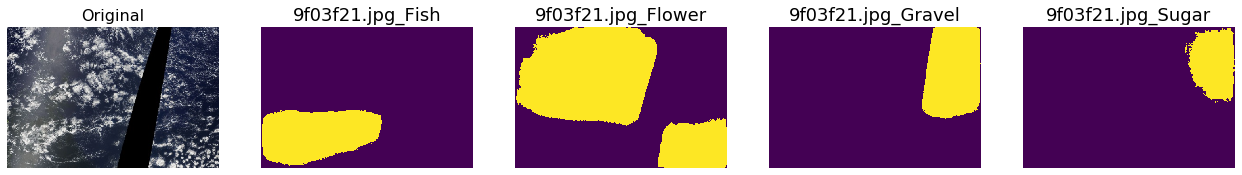

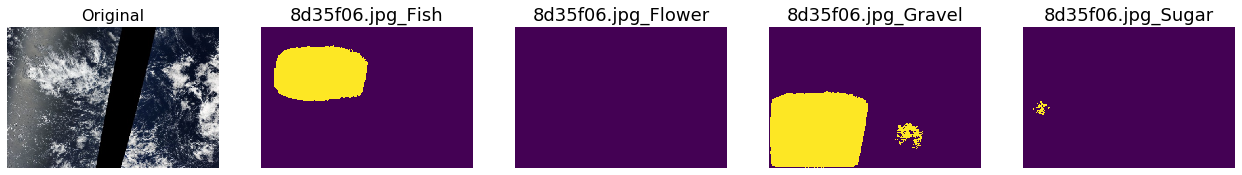

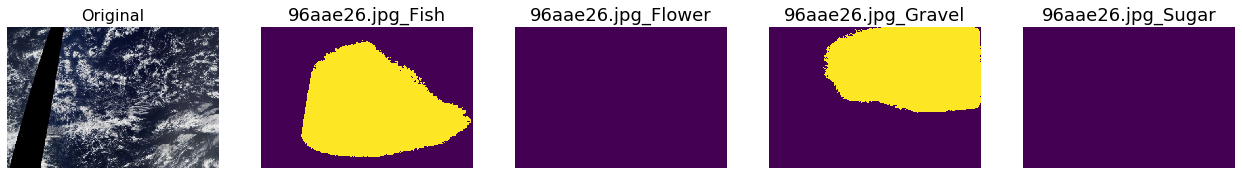

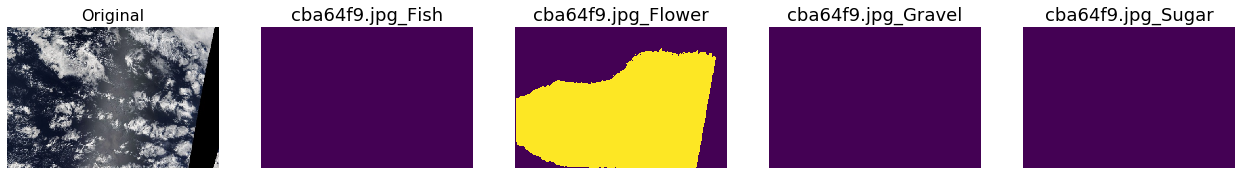

In [21]:
images_to_inspect_test =  np.random.choice(X_test['image'].unique(), 4, replace=False)
inspect_predictions(X_test, images_to_inspect_test, test_images_path)

### With post-process

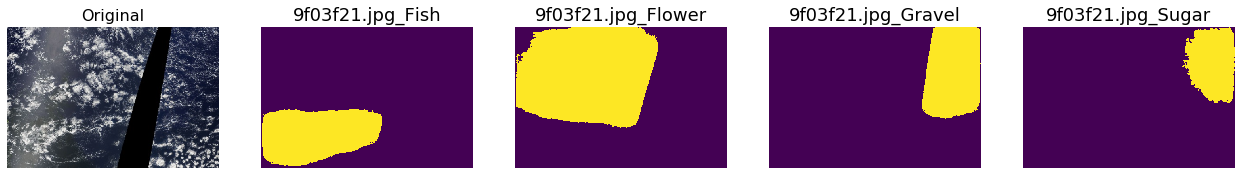

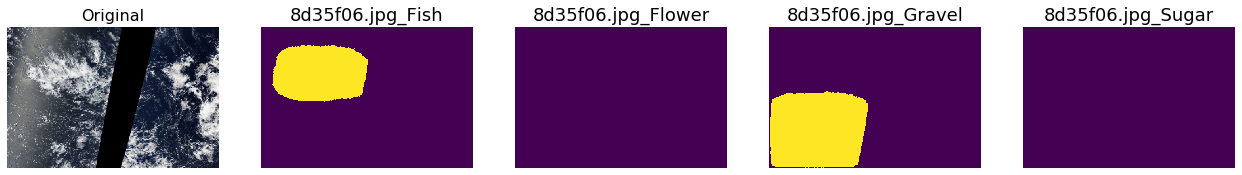

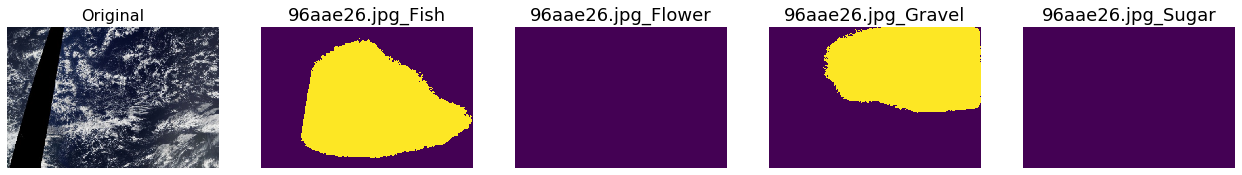

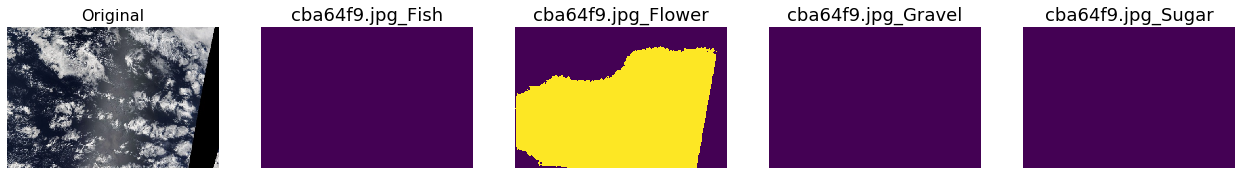

In [22]:
inspect_predictions(X_test, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post')

### Without post-process and TTA

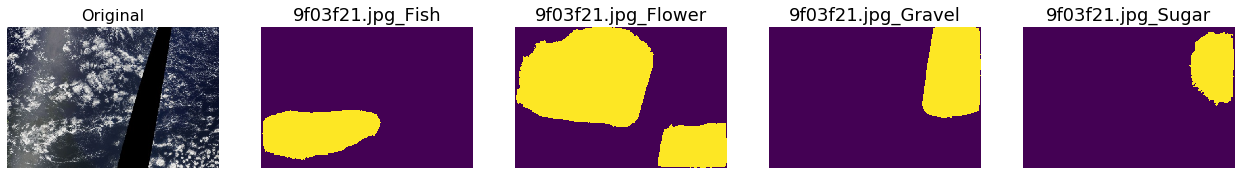

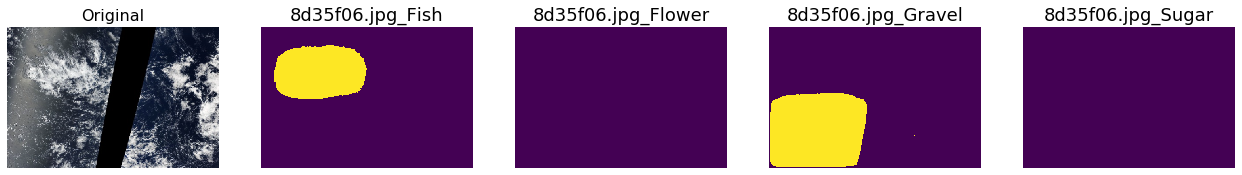

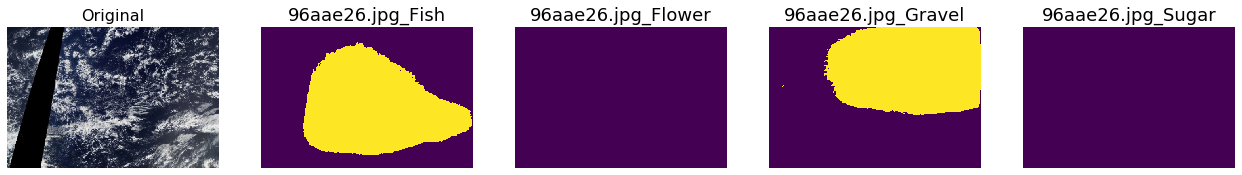

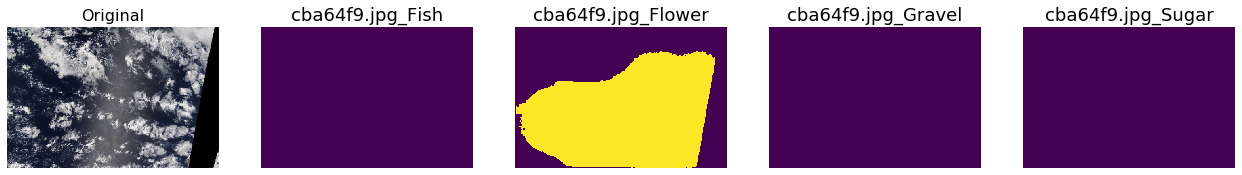

In [23]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_tta')

### With post-process and TTA

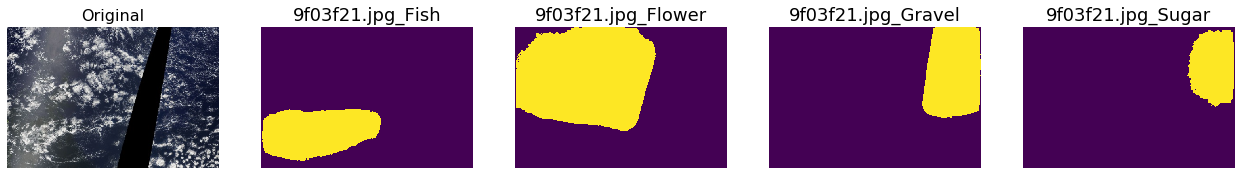

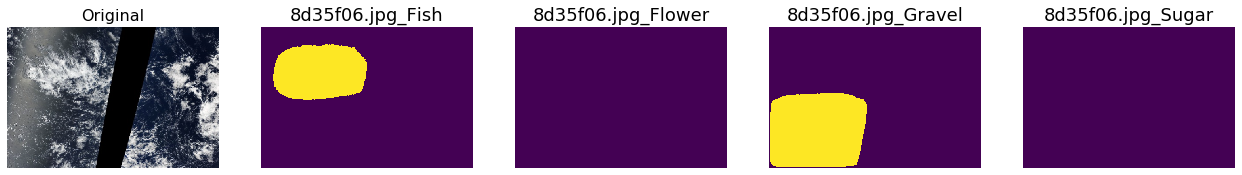

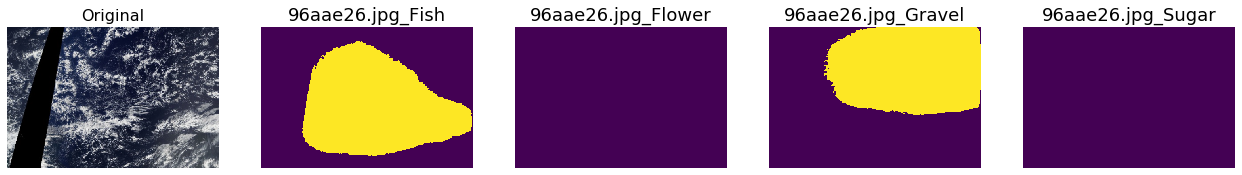

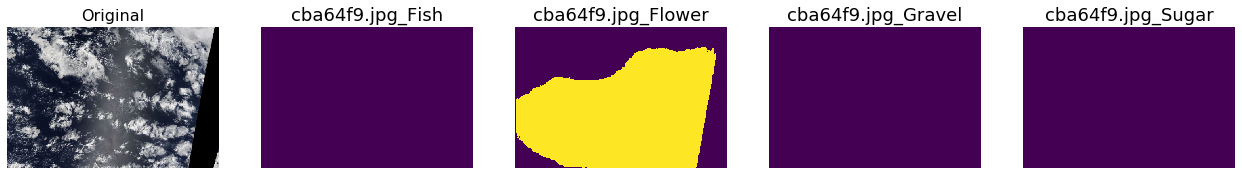

In [24]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_tta')

### Submission with post processing

In [25]:
submission_df = X_test[['Image_Label' ,'EncodedPixels_post']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,15 255 273 6 282 30 319 1 365 255 623 6 632 30...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing and mask classification (beta 0.5)

In [26]:
submission_df = X_test[['Image_Label' ,'EncodedPixels_post_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_class_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,15 255 273 6 282 30 319 1 365 255 623 6 632 30...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing and mask classification (beta 1)

In [27]:
submission_df = X_test[['Image_Label' ,'EncodedPixels_post_class2']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_class2_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,15 255 273 6 282 30 319 1 365 255 623 6 632 30...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing and TTA

In [28]:
submission_df = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_tta_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,18 288 319 1 368 288 669 1 715 306 1057 335 14...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing, mask classification and TTA (beta 0.5)

In [29]:
submission_df = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_tta_class_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,18 288 319 1 368 288 669 1 715 306 1057 335 14...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing, mask classification and TTA (beta 1)

In [30]:
submission_df = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta_class2']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_tta_class2_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,18 288 319 1 368 288 669 1 715 306 1057 335 14...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,
